# Non-Markovianity

## data

In [1]:
import qsvm.Qmapping as Q
import qsvm.data_function as df
import numpy as np
import matplotlib.pyplot as plt
from qsvm.qsvm import Pca,QSVM

In [2]:
f = open('./Datasets/standard_quantum.json', 'r') 
tg = json.load(f)
f.close()
traindata = tg['train']['data']
testdata = tg['test']['data']
trainlabels = tg['train']['label']
testlabels = tg['test']['label']

In [3]:
interval=np.linspace(0,0.06,7)

In [4]:
categories = [f"{round(interval[i],3)}-{round(interval[i+1],3)}" for i in range(len(interval)-1) ]
values=[ 0 for _ in range(len(interval)-1)]
for da in trainlabels:
    for i in range(len(categories)):
        if interval[i]<da<=interval[i+1]:
            values[i]+=1

In [5]:
categories

['0.0-0.01', '0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05', '0.05-0.06']

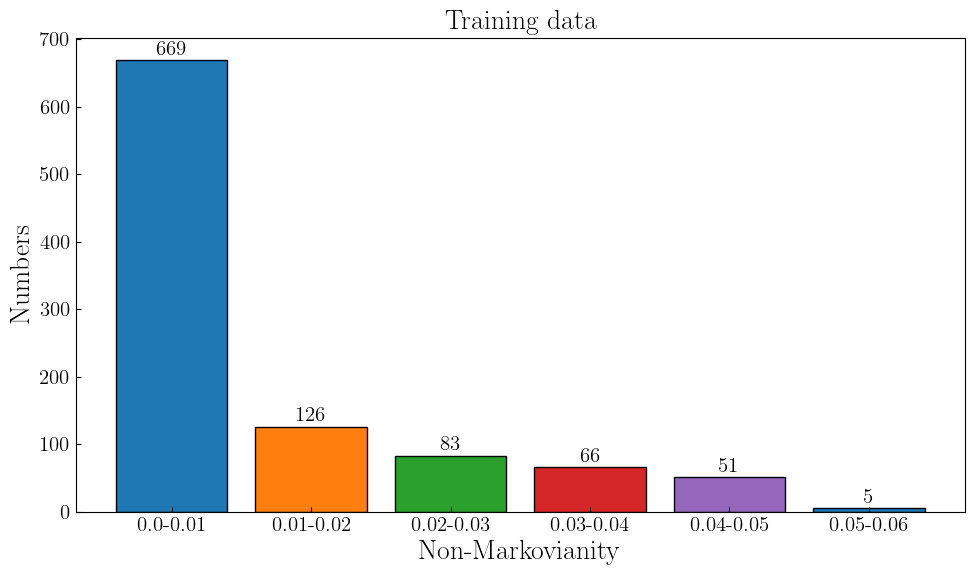

In [6]:

# 设置图表大小和风格
plt.figure(figsize=(10, 6))
# plt.style.use('seaborn-darkgrid')

# 创建柱状图
bars = plt.bar(categories, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], edgecolor='black')

# 添加标题和标签
plt.title('Training data', fontsize=20, fontweight='bold')
plt.xlabel('Non-Markovianity', fontsize=20)
plt.ylabel('Numbers', fontsize=20)

# 添加数据标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 2, int(yval), ha='center', va='bottom', fontsize=15)

# 添加网格
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 显示图表
plt.show()

In [7]:
interval=np.linspace(0,0.06,7)

In [8]:
categories = [f"{round(interval[i],3)}-{round(interval[i+1],3)}" for i in range(len(interval)-1) ]
values=[ 0 for _ in range(len(interval)-1)]
for da in testlabels:
    for i in range(len(categories)):
        if interval[i]<da<=interval[i+1]:
            values[i]+=1

In [9]:
categories

['0.0-0.01', '0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05', '0.05-0.06']

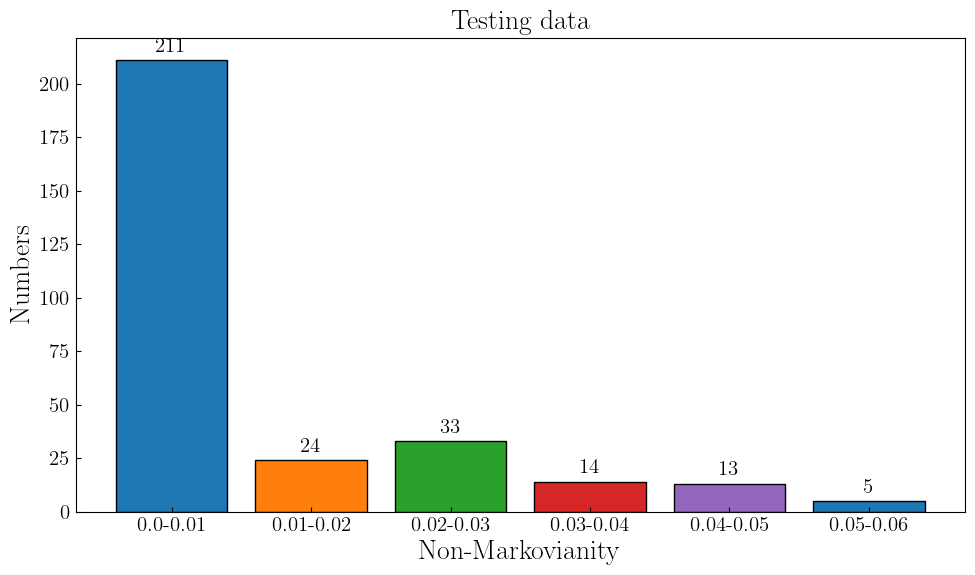

In [10]:

# 设置图表大小和风格
plt.figure(figsize=(10, 6))
# plt.style.use('seaborn-darkgrid')

# 创建柱状图
bars = plt.bar(categories, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], edgecolor='black')

# 添加标题和标签
plt.title('Testing data', fontsize=20, fontweight='bold')
plt.xlabel('Non-Markovianity', fontsize=20)
plt.ylabel('Numbers', fontsize=20)

# 添加数据标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 2, int(yval), ha='center', va='bottom', fontsize=15)

# 添加网格
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 显示图表
plt.show()

## Data pre-processing

In [11]:
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse


### PCA

In [39]:
pca=Pca(PCA_n=10,StandardizeOrNot=False,sklearnPCA=True)

In [40]:
pca.fitting(traindata)
svm_tr_data=pca.transform(traindata)
svm_te_data=pca.transform(testdata)

# Renormalize each feature
svm_tr_data=pca.Renormalize_Each_Feature(svm_tr_data,Norm=np.pi/2,status="train")
svm_te_data=pca.Renormalize_Each_Feature(svm_te_data,Norm=np.pi/2)

## Construct Quantum Kernal

In [41]:
import time

In [42]:
qsvm=QSVM(task='svr')
qsvm.default_phys_sys()

In [43]:
# error=[0.005,0.01,0.1]
error=[]
start_time = time.time()
tr_kernel=qsvm.get_kernel(svm_tr_data,tier=1,method="analog+digital", op="x",Error=error)
te_kernel=qsvm.get_kernel(svm_te_data,status="test",tier=1,method="analog+digital", op="x",Error=error)
end_time=time.time()

In [44]:
cost_time=end_time-start_time

In [45]:
print(cost_time)

36.71761465072632


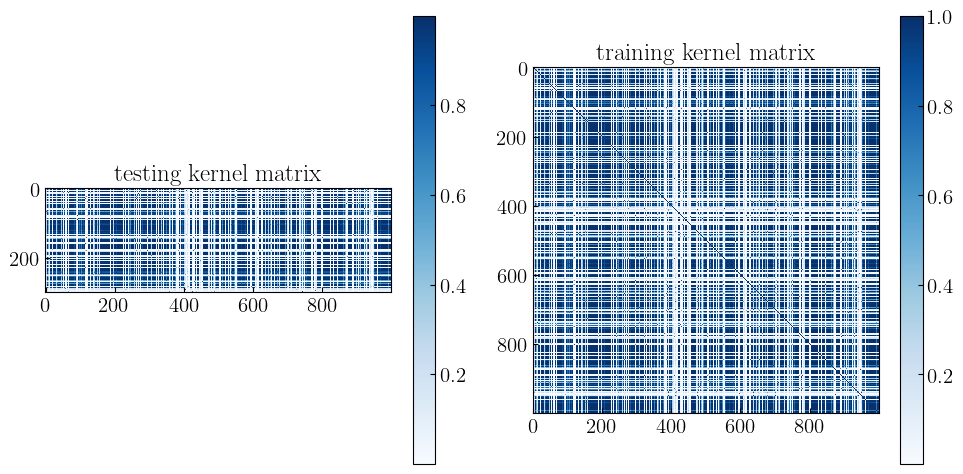

In [46]:
Q.show_kmatrix(train = tr_kernel , test = te_kernel,name = "")

## Supported Vector Machine

### Quantum kernel

In [47]:
from sklearn.svm import SVR
import sklearn

In [48]:
# svr = SVR()
argv = df._tune(np.array(tr_kernel) , trainlabels ,np.array(te_kernel) , testlabels, ['precomputed'] , tg = 'ts' )
argv

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


{'kernel': 'precomputed', 'epsilon': 0.0, 'C': 0.6}

In [49]:
qsvm.fit(tr_kernel, trainlabels, epsilon = argv['epsilon'] , C = argv['C'])

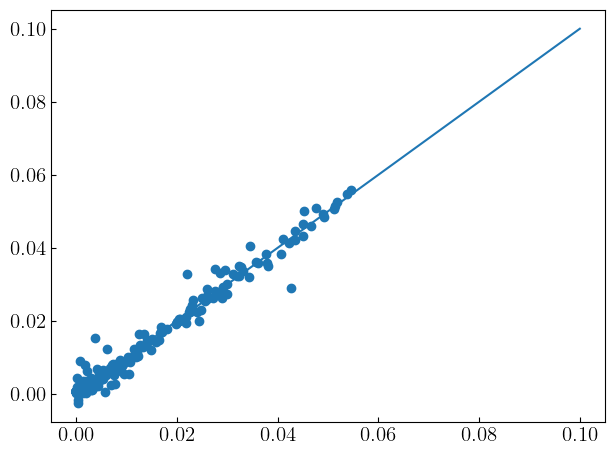

In [50]:
rs_t=qsvm.predict(te_kernel)
df._plot(testlabels , rs_t , 99 , name = '')

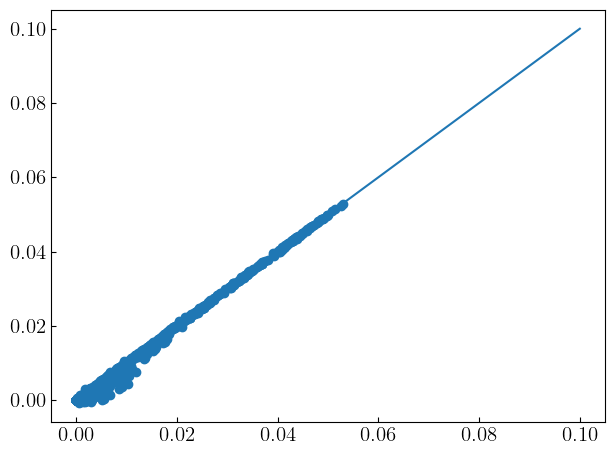

In [51]:
rs = qsvm.predict(tr_kernel)
df._plot(trainlabels , rs ,99 , name = '')

### linear

In [52]:

traindata=np.array(svm_tr_data)
testdata=np.array(svm_te_data)

_k = sklearn.metrics.pairwise.linear_kernel(svm_tr_data)
_kk = sklearn.metrics.pairwise.linear_kernel(svm_te_data,svm_tr_data)

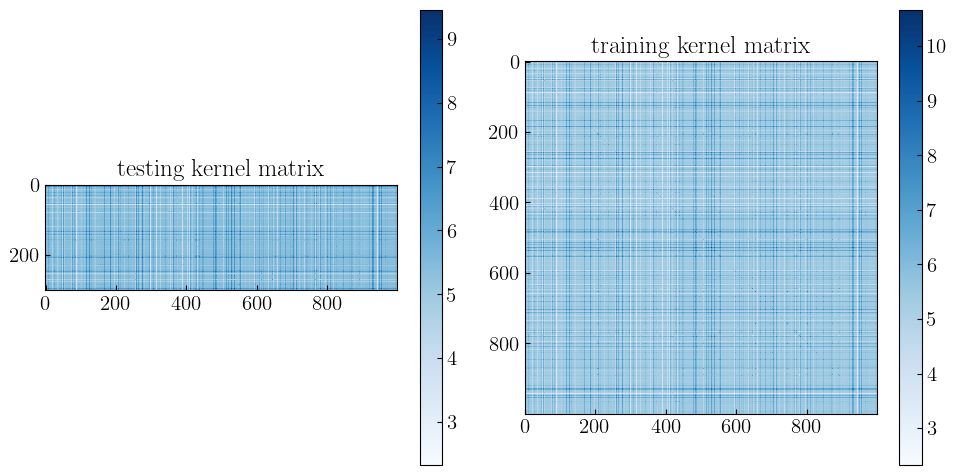

In [53]:
Q.show_kmatrix(test = _kk , train = _k , name = '')

In [54]:
mth = 'linear'
linear_svr = SVR()
argv = df.tune(linear_svr,svm_tr_data , trainlabels , [mth])
argv

{'kernel': 'linear', 'epsilon': 0.018000000000000002, 'C': 0.6}

In [55]:
linear_svr = SVR(kernel = mth , epsilon = 0, C=0.9)
linear_svr.fit(svm_tr_data, trainlabels)

SVR(C=0.9, epsilon=0, kernel='linear')

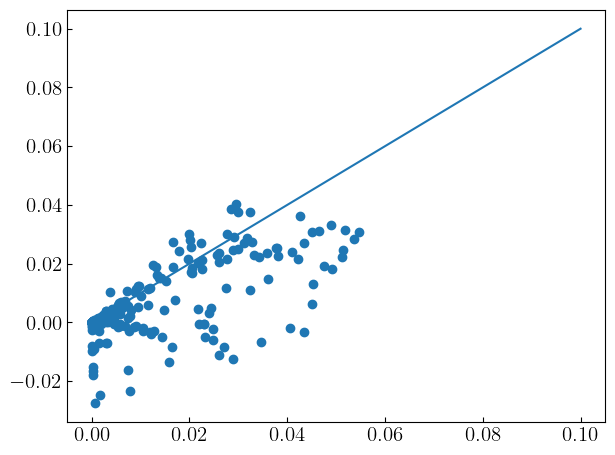

In [56]:
linear_rs_t = linear_svr.predict(svm_te_data)
df._plot(testlabels , linear_rs_t , 999 , name = '')

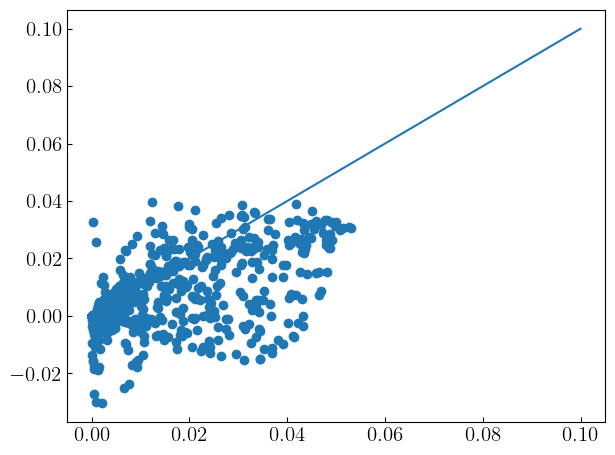

In [57]:
linear_rs = linear_svr.predict(svm_tr_data)
df._plot(trainlabels , linear_rs , 999 , name = '')

### rbf

In [58]:

traindata=np.array(svm_tr_data)
testdata=np.array(svm_te_data)

_k = sklearn.metrics.pairwise.rbf_kernel(svm_tr_data,gamma=1/(10*traindata.var()))
_kk = sklearn.metrics.pairwise.rbf_kernel(svm_te_data,svm_tr_data,gamma=1/(10*traindata.var()))

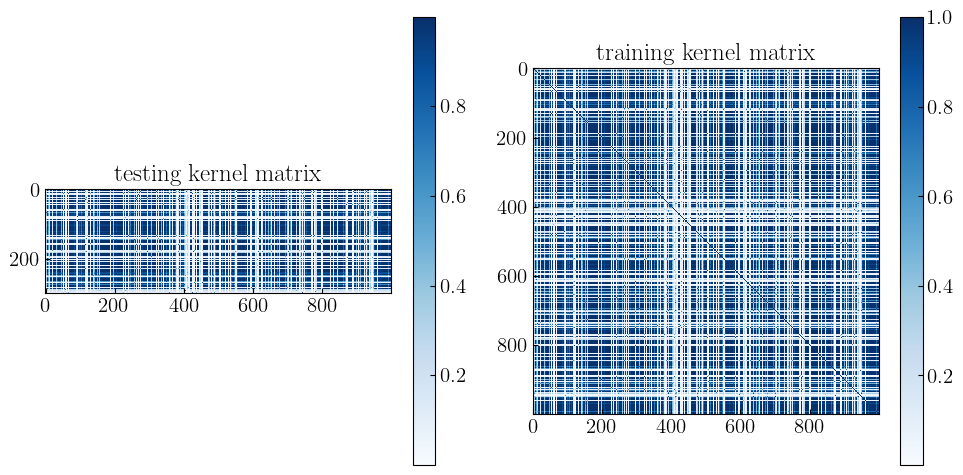

In [59]:
Q.show_kmatrix(test = _kk , train = _k , name = '')

In [60]:
mth = 'rbf'
_svr = SVR()
argv = df.tune(_svr,svm_tr_data , trainlabels , [mth])
argv

{'kernel': 'rbf', 'epsilon': 0.013000000000000001, 'C': 0.6}

In [61]:
_svr = SVR(kernel = mth , epsilon = 0, C=0.9)
_svr.fit(svm_tr_data, trainlabels)

SVR(C=0.9, epsilon=0)

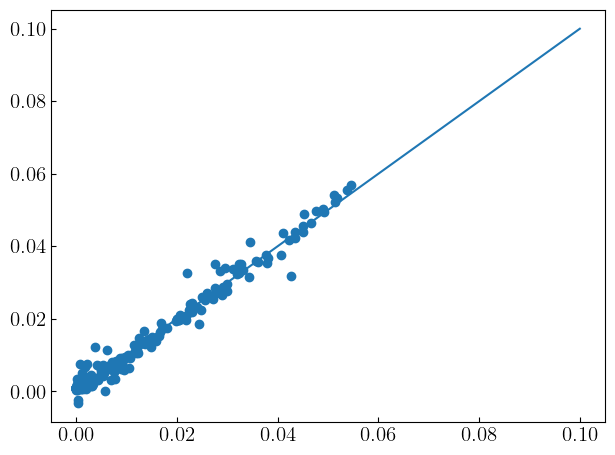

In [62]:
_rs_t = _svr.predict(svm_te_data)
df._plot(testlabels , _rs_t , 999 , name = '')

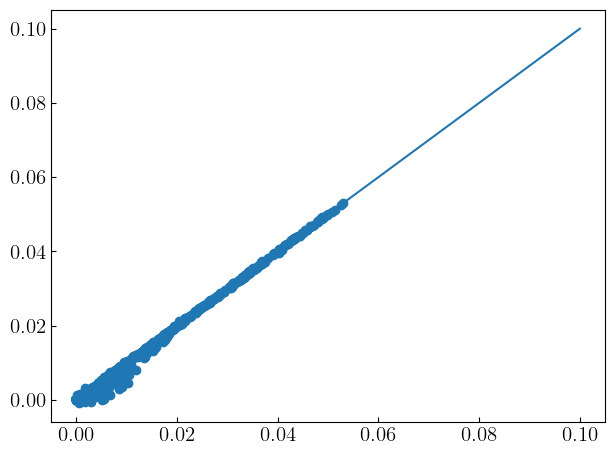

In [63]:
_rs = _svr.predict(svm_tr_data)
df._plot(trainlabels , _rs , 999 , name = '')

## Result

In [64]:
print(f'Classical linear testing mse : {mse(linear_rs_t , testlabels)}')
print(f'Classical rbf testing mse : {mse(_rs_t , testlabels)}')
print(f'Quantum testing mse : {mse(rs_t,testlabels)}')

Classical linear testing mse : 0.00011996892354734144
Classical rbf testing mse : 3.7136830626514038e-06
Quantum testing mse : 4.0063348167627e-06


In [65]:
print(f'Classical linear training mse : {mse(linear_rs , trainlabels)}')
print(f'Classical rbf training mse : {mse(_rs , trainlabels)}')
print(f'Quantum training mse : {mse(rs,trainlabels)}')

Classical linear training mse : 0.0001483131249359012
Classical rbf training mse : 5.75980027138263e-07
Quantum training mse : 6.235208451650996e-07
